In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import random

In [2]:
DATA_DIR = "training"

In [3]:
IMG_DIR = os.path.join(DATA_DIR, "images")
IMG_DIR

'training/images'

In [4]:
LABEL_DIR = os.path.join(DATA_DIR, "labels")
LABEL_DIR

'training/labels'

In [5]:
classes = np.genfromtxt(os.path.join(LABEL_DIR, 'classes.txt'), dtype='str')
classes

array(['door', 'window', 'zone'], dtype='<U6')

# Read and Plot data

(905, 1094, 3)


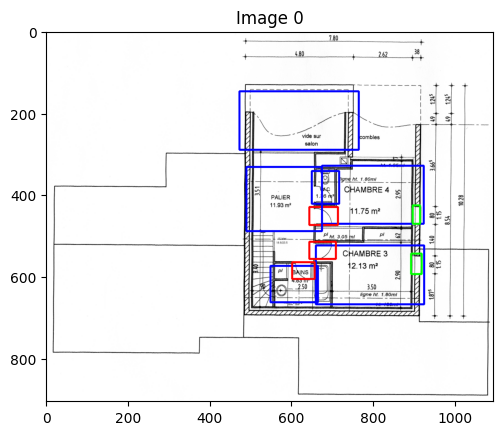

(2234, 3110, 3)


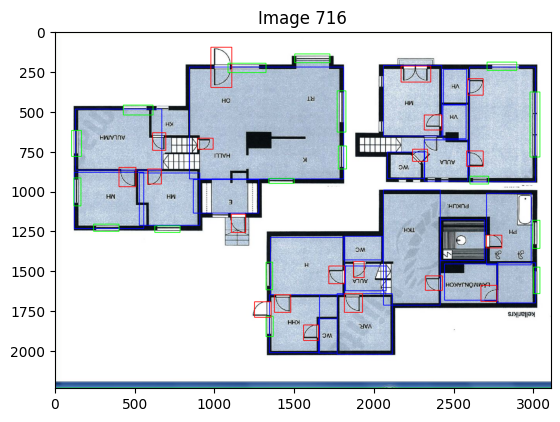

In [6]:
def get_data(img_id):
    
    label_path = os.path.join(LABEL_DIR, "%d.txt" %img_id)
    data = np.loadtxt(label_path)
    
    img_path = os.path.join(IMG_DIR, "%d.png" % img_id)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    labels = data[:, 0]
    labels = labels.astype(np.int8)
    
    boxes = data[:, 1:]

    boxes[:,0] -= boxes[:,2]/2
    boxes[:,1] -= boxes[:,3]/2
    boxes[:,2] += boxes[:,0]
    boxes[:,3] += boxes[:,1]

    # print(img.shape)
    # print(img)
    
    return img, labels, boxes

def scale_box(boxes, width, height):
    boxes[:,0] = boxes[:,0] * width
    boxes[:,1] = boxes[:,1] * height
    boxes[:,2] = boxes[:,2] * width
    boxes[:,3] = boxes[:,3] * height
    return boxes

def plot_data(img_id, img, labels, boxes):

    if np.max(boxes) < 1:
        height, width = img.shape[:2] 
        boxes = scale_box(boxes, width, height)
    
    boxes = np.round(boxes).astype(np.int32)
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    for label, box in zip(labels, boxes):
        cv2.rectangle(img,
                      (box[0], box[1]),
                      ( box[2], box[3]),
                      colors[label], 3)

    plt.imshow(img)
    plt.title("Image %d" %img_id)
    plt.show()
    

def plot_img(img_id):
    img, labels, boxes = get_data(img_id)
    print(img.shape)
    plot_data(img_id, img, labels, boxes)
    
plot_img(0)
plot_img(716)

# Find Image IDs

In [7]:
png_files = [file for file in os.listdir(IMG_DIR) if file.endswith('.png')]
img_ids = [int(os.path.splitext(file)[0]) for file in png_files]
img_ids = sorted(img_ids)
img_ids[:10]

[0, 2, 3, 4, 7, 521, 522, 525, 526, 528]

# Split IDs into Train And Test Randomly

In [8]:
random.seed(0)
random.shuffle(img_ids)
test_ratio = 0.3
total_samples = len(img_ids)
num_train = round(total_samples * (1-test_ratio))
train_ids = img_ids[:num_train]
test_ids = img_ids[num_train:]
print("total samples: %d" % len(img_ids))
print("train samples: %d" % len(train_ids))
print("test samples: %d" % len(test_ids))

total samples: 2681
train samples: 1877
test samples: 804


# Implement PyTorch Dataset

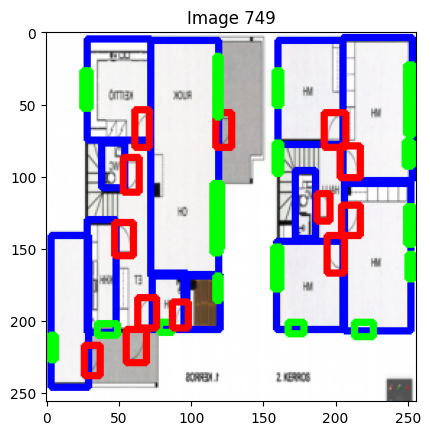

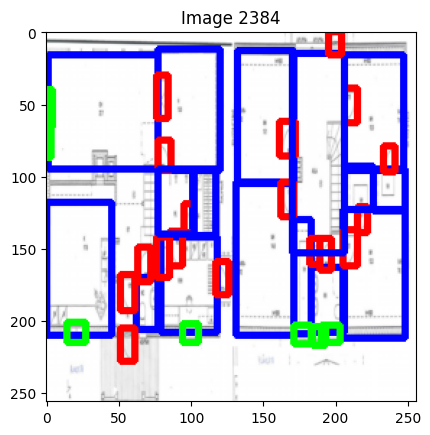

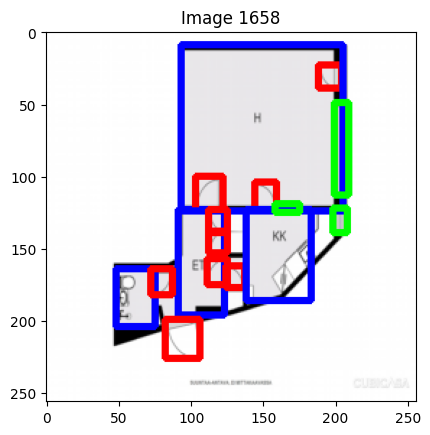

In [9]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

class FloorplanDataset(Dataset):

    def __init__(self, ids, transform=transform):
        super().__init__()
        self.ids = ids
        self.transform = transform

    def __len__(self) -> int:
        return len(self.ids)

    def __getitem__(self, i: int):
        
        img_id = self.ids[i]
        img, labels, boxes = get_data(img_id)
        img = img / 255.0
        
        if self.transform:
            img = self.transform(img)
            boxes = scale_box(boxes, width=img.shape[2], height = img.shape[1])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int8)
        return img_id, img, labels, boxes


train_set = FloorplanDataset(train_ids)
test_set = FloorplanDataset(test_ids)

def collate_fn(batch):
    return zip(*batch)

train_loader = DataLoader(
    train_set,
    batch_size=32,
    # num_workers=8,
    shuffle=False,
    collate_fn = collate_fn
)

test_loader = DataLoader(
    test_set,
    batch_size=32,
    # num_workers=8,
    shuffle=False,
    collate_fn = collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Test by plot 3 images from training set
img_ids, imgs, labelss, boxess = next(iter(train_loader))

count = 0
for img_id, img, labels, boxes in zip(img_ids, imgs, labelss, boxess):
    img = img.to(device).permute(1,2,0).cpu().numpy() * 255
    img = img.astype(np.uint8).copy()
    boxes = boxes.to(device).cpu().numpy().astype(np.uint32)
    plot_data(img_id, img, labels, boxes)
    count+=1
    if count == 3:
        break
